In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. Load and prepare the data

In [2]:
train = pd.read_csv('./train.csv') # training set
test = pd.read_csv('./test.csv') # test set

train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# We'll use "PassengerId" as index (it'll start with 1),
# and drop the "Name" column because it makes no sense for model
train = train.set_index('PassengerId').drop('Name', axis = 1) 
# Change the values in "Sex" column ('male' = 1, 'female' = 0)
train = train.replace({'Sex' : {'male' : 1, 'female' : 0}})
# Change "Embarked" column: 'S' = 0, 'C' = 1, 'Q' = 2
train = train.replace({'Embarked' : {'S' : 0, 'C' : 1, 'Q' : 2}})
# We also may drop the "Ticket", "Fare", and "Cabin" columns 
train = train.drop(['Ticket', 'Fare', 'Cabin'], axis = 1)

In [4]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
PassengerId,,,,,,,
1,0,3,1,22.0,1,0,0.0
2,1,1,0,38.0,1,0,1.0
3,1,3,0,26.0,0,0,0.0
4,1,1,0,35.0,1,0,0.0
5,0,3,1,35.0,0,0,0.0
...,...,...,...,...,...,...,...
887,0,2,1,27.0,0,0,0.0
888,1,1,0,19.0,0,0,0.0
889,0,3,0,NaN,1,2,0.0


# 2. Linear logistic regression

So we have 7 features, and 891 training examples:  

* Pclass - Passenger class (3 - lowest, 1 - highest)
* Sex
* Age
* SibSp - # of siblings / spouses aboard the Titanic
* Parch - # of parents / children aboard the Titanic
* Embarked - Port of Embarkation (0 = Southampton, 1 = Cherbourg, 2 = Queenstown)  

Our label vector is *Survived* column  

Let's prepare our data for model

In [5]:
# It's necessary to implement normalization of "Age" column
mean_age = train.Age.mean()
age_deviation = train.Age.std()
train.Age = (train.Age - mean_age)/(age_deviation + 10**(-8))
# And we will repalce NaN ages with its average value
train.Age = train.Age.fillna(train.Age.mean())
# Alse we need to fill NaN Embarked positions
# I fill with 2, (assume that these passengers were the last who went on the ship)
train.Embarked = train.Embarked.fillna(2)

train

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
PassengerId,,,,,,,
1,0,3,1,-5.300051e-01,1,0,0.0
2,1,1,0,5.714304e-01,1,0,1.0
3,1,3,0,-2.546462e-01,0,0,0.0
4,1,1,0,3.649113e-01,1,0,0.0
5,0,3,1,3.649113e-01,0,0,0.0
...,...,...,...,...,...,...,...
887,0,2,1,-1.858065e-01,0,0,0.0
888,1,1,0,-7.365243e-01,0,0,0.0
889,0,3,0,2.388379e-16,1,2,0.0


Let's separate dataset into training set and cross-validation set

In [6]:
X_train = train.loc[:799, 'Pclass':]
Y_train = train.loc[:799, 'Survived'].to_numpy().reshape((X_train.shape[0], 1))
# ~ 10% for cross-validation set 
X_val = train.loc[800:, 'Pclass':]
Y_val = train.loc[800:, 'Survived'].to_numpy().reshape((X_val.shape[0], 1))

In [7]:
def initialize_parameters_regr(n, null = False):
    
    # Initialize parameters for Logistic Regression model
    # W - weights, b - bias unit, (W.shape == (n, 1))
    # If null == false W and b are gaussian distributed random variable with mean == 0 and variance == 1
    # else W and b are zeros
    # n - number of features
    # return parameters = {'W' : W_values, 'b' : b_value}
    
    parameters = dict()
    
    parameters['W'] = np.random.randn(n, 1)
    parameters['b'] = np.random.randn()
    
    if null is True:
        parameters['W'] = 0 * parameters['W']
        parameters['b'] = 0 * parameters['b']
    
    return parameters

In [8]:
parameters_test = initialize_parameters_regr(2, null = True)
parameters_test

{'W': array([[ 0.],
        [-0.]]),
 'b': -0.0}

In [9]:
def sigmoid(Z):
    
    return 1 / (1 + np.exp(-Z))

In [10]:
sigmoid(0)

0.5

In [11]:
def compute_cost_regr(X, Y, parameters, lambd = 0):
    
    # Compute cost and gradients
    # grads - dictionary with gradients
    # return cost, grads
    
    W = parameters['W']
    b = parameters['b']
    m = X.shape[0]
    cost = 0
    grads = dict()
    
    Z = np.dot(X, W) + b
    A = sigmoid(Z)
    
    # Cross-entropy cost function
    cost = -1/m * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) + lambd/(2*m) * np.sum(W**2)
                         
    grads['dW'] = 1/m * np.dot(X.T, A-Y) + lambd/m * W
    grads['db'] = 1/m * np.sum(A - Y)
    
    return cost, grads

In [12]:
def update_parameters_regr(parameters, grads, learning_rate = 0.001):
    
    parameters['W'] = parameters['W'] - learning_rate * grads['dW']
    parameters['b'] = parameters['b'] - learning_rate * grads['db']
    
    return parameters

In [13]:
def model_regr(X, Y, num_iterations = 15000, learning_rate = 0.01, lambd = 0, null = False, plot_cost = False):
    
    (m, n) = X.shape
    parameters = initialize_parameters_regr(n, null)
    costs = list()
    
    for i in range(num_iterations):
        
        cost, grads = compute_cost_regr(X, Y, parameters, lambd)
        if i % 100 == 0:
            costs.append(cost)  
        parameters = update_parameters_regr(parameters, grads, learning_rate)
        
        if i % 1000 == 0:
            print('Cost after {} iterations: {}'.format(i, cost))
    
    if plot_cost is True:
        plt.plot(costs)
        plt.title('Cost with learning rate = {}, lambda = {}, num iter = {}'.format(learning_rate, lambd, num_iterations))
        plt.xlabel('iterations (per 100)')
        plt.ylabel('Cost')
        plt.show()
    
    
    return parameters

In [14]:
def prediction_regr(X, Y, parameters):
    
    W = parameters['W']
    b = parameters['b']
    
    Z_pred = np.dot(X, W) + b
    A_pred = sigmoid(Z_pred)
    Y_pred = np.round(A_pred)
    
    pred = np.mean(Y_pred == Y) * 100
    
    return pred, Y_pred

Cost after 0 iterations: 0.6931471805599453
Cost after 1000 iterations: 0.5498649901650626
Cost after 2000 iterations: 0.5167125364150741
Cost after 3000 iterations: 0.49791200450877543
Cost after 4000 iterations: 0.48540860980128325
Cost after 5000 iterations: 0.47644742360452325
Cost after 6000 iterations: 0.469753119780909
Cost after 7000 iterations: 0.46462217960126434
Cost after 8000 iterations: 0.4606207911879898
Cost after 9000 iterations: 0.457460691853957
Cost after 10000 iterations: 0.45494040374210665
Cost after 11000 iterations: 0.45291418138349365
Cost after 12000 iterations: 0.4512740323238715
Cost after 13000 iterations: 0.44993851596615064
Cost after 14000 iterations: 0.44884536909390227


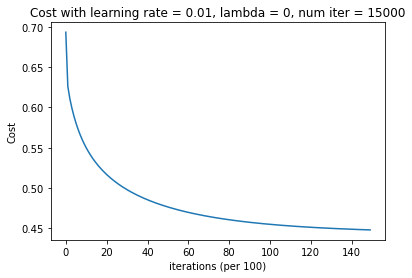

## Linear logistic regression ##

ACCURACY ON TRAINING SET   80.35043804755945 %
ACCURACY ON CROSS_VALIDATION SET   78.26086956521739 %


{'W': array([[-0.8872075 ],
        [-2.38980319],
        [-0.431441  ],
        [-0.22896546],
        [-0.01842962],
        [ 0.2765088 ]]),
 'b': 2.9651432687412895}

In [15]:

parameters_regr = model_regr(X_train, Y_train, null = True, plot_cost = True)
pred_train, Y_pred_train = prediction_regr(X_train, Y_train, parameters_regr)
pred_val, Y_pred_val = prediction_regr(X_val, Y_val, parameters_regr)
print('## Linear logistic regression ##\n')
print('ACCURACY ON TRAINING SET   {} %'.format(pred_train))
print('ACCURACY ON CROSS_VALIDATION SET   {} %'.format(pred_val))
parameters_regr

### Confusion matrix

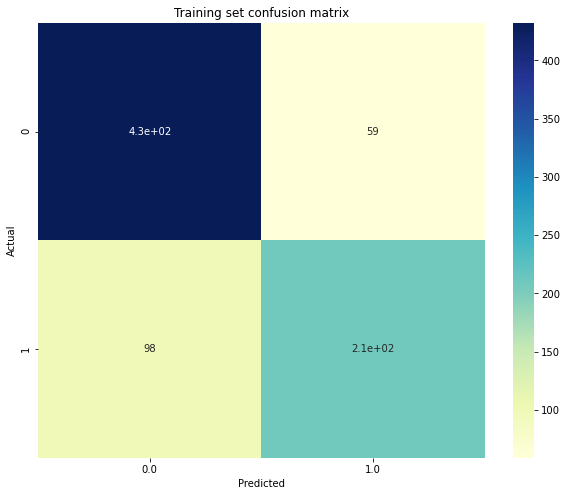

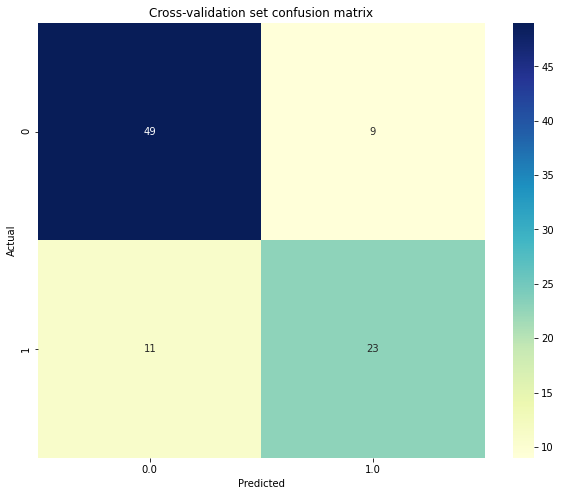

In [16]:
df_train = pd.DataFrame(data = {'Y_Actual_train' : Y_train.squeeze(), 'Y_Pred_train' : Y_pred_train.squeeze()})
df_val = pd.DataFrame(data = {'Y_Actual_val' : Y_val.squeeze(), 'Y_Pred_val' : Y_pred_val.squeeze()})
conf_matrix_train = pd.crosstab(df_train['Y_Actual_train'], df_train['Y_Pred_train'], rownames = ['Actual'], colnames = ['Predicted'])
conf_matrix_val = pd.crosstab(df_val['Y_Actual_val'], df_val['Y_Pred_val'], rownames = ['Actual'], colnames = ['Predicted'])
# Confusion matrix for training set
plt.figure(figsize = (10, 8))
sns.heatmap(data = conf_matrix_train, annot = True, cmap = "YlGnBu")
plt.title('Training set confusion matrix')
plt.show()
# Confusion matrix for cross_validation set
plt.figure(figsize = (10, 8))
sns.heatmap(data = conf_matrix_val, annot = True, cmap = "YlGnBu")
plt.title('Cross-validation set confusion matrix')
plt.show()

# 3. Make submission for Kaggle

Load test set, make prediction and convert it into csv-file

In [17]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [18]:
# Drop the "Name" column because it makes no sense for model
test = test.drop('Name', axis = 1) 
# Change the values in "Sex" column ('male' = 1, 'female' = 0)
test = test.replace({'Sex' : {'male' : 1, 'female' : 0}})
# Change "Embarked" column: 'S' = 0, 'C' = 1, 'Q' = 2
test = test.replace({'Embarked' : {'S' : 0, 'C' : 1, 'Q' : 2}})
# We also may drop the "Ticket", "Fare", and "Cabin" columns 
test = test.drop(['Ticket', 'Fare', 'Cabin'], axis = 1)

In [19]:
test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked
0,892,3,1,34.5,0,0,2
1,893,3,0,47.0,1,0,0
2,894,2,1,62.0,0,0,2
3,895,3,1,27.0,0,0,0
4,896,3,0,22.0,1,1,0
...,...,...,...,...,...,...,...
413,1305,3,1,NaN,0,0,0
414,1306,1,0,39.0,0,0,1
415,1307,3,1,38.5,0,0,0
416,1308,3,1,NaN,0,0,0


In [20]:
test.Embarked = test.Embarked.fillna(2)
test.Age = (test.Age.fillna(mean_age) - mean_age) / (age_deviation + 10**(-8))

In [21]:
test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked
0,892,3,1,0.330491,0,0,2
1,893,3,0,1.190988,1,0,0
2,894,2,1,2.223584,0,0,2
3,895,3,1,-0.185807,0,0,0
4,896,3,0,-0.530005,1,1,0
...,...,...,...,...,...,...,...
413,1305,3,1,0.000000,0,0,0
414,1306,1,0,0.640270,0,0,1
415,1307,3,1,0.605850,0,0,0
416,1308,3,1,0.000000,0,0,0


In [22]:
pred, Y_subm = prediction_regr(test.loc[:, 'Pclass' : 'Embarked'], np.zeros((418, 1)), parameters_regr)
Y_subm[0:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [1.]])

In [23]:
test['Survived'] = Y_subm

In [25]:
test.set_index('PassengerId')['Survived'].astype('int').to_csv('./submission.csv')